# Variational Autoencoder: LeNet-5 CNN with PyTorch and MNIST

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import numpy as np

C:\Users\arjun\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 60
batch_size = 256
learning_rate = 0.001

### MNIST data pre-processing:

#### Compute mean and standard deviation for different datasets

```
import argparse
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

dataset_names = ('cifar10','cifar100','mnist')

parser = argparse.ArgumentParser(description='PyTorchLab')
parser.add_argument('-d', '--dataset', metavar='DATA', default='cifar10', choices=dataset_names,
                    help='dataset to be used: ' + ' | '.join(dataset_names) + ' (default: cifar10)')

args = parser.parse_args()

data_dir = os.path.join('.', args.dataset)

print(args.dataset)

if args.dataset == "cifar10":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(train_set.train_data.mean(axis=(0,1,2))/255)
    print(train_set.train_data.std(axis=(0,1,2))/255)

elif args.dataset == "cifar100":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(np.mean(train_set.train_data, axis=(0,1,2))/255)
    print(np.std(train_set.train_data, axis=(0,1,2))/255)

elif args.dataset == "mnist":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(list(train_set.train_data.size()))
    print(train_set.train_data.float().mean()/255)
    print(train_set.train_data.float().std()/255)
```

[Reference](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/11)

In [7]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [8]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = 'C:/Users/arjun/Downloads/data/', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = 'C:/Users/arjun/Downloads/data', train = False,
        transform = transforms_apply
        )

In [9]:
# Sanity check-
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [10]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f} &"
      f" std dev = {train_dataset.data.float().std() / 255:.4f}"
     )

mean = 0.1307 & std dev = 0.3081


#### NOTE:

Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [11]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [12]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

#### Scale pixel values in the range 0 to 1

To manually convert the pixel values in the range 0 to 1.

In [13]:
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [14]:
type(train), type(test)

(torch.Tensor, torch.Tensor)

In [15]:
train.shape, test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [16]:
# Reshape to include gray-scale channel-
train = train.reshape(60000, 1, 28, 28)
test = test.reshape(10000, 1, 28, 28)

In [17]:
train.shape, test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [18]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [19]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [20]:
del train_dataset, test_dataset

In [21]:
print(f"batch size to be used = {batch_size}")

batch size to be used = 256


In [22]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test, batch_size = batch_size,
        shuffle = False
        )

In [23]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 235 and test_loader: 40


In [24]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [25]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(234.375, 39.0625)

In [26]:
# Get some random batch of training images & labels-
images = next(iter(train_loader))
print(f"images.shape: {images.shape}")

images.shape: torch.Size([256, 1, 28, 28])


In [27]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [28]:
# De-normalize the batch of images-
images *= 255.0

In [29]:
images.min(), images.max()

(tensor(0.), tensor(255.))

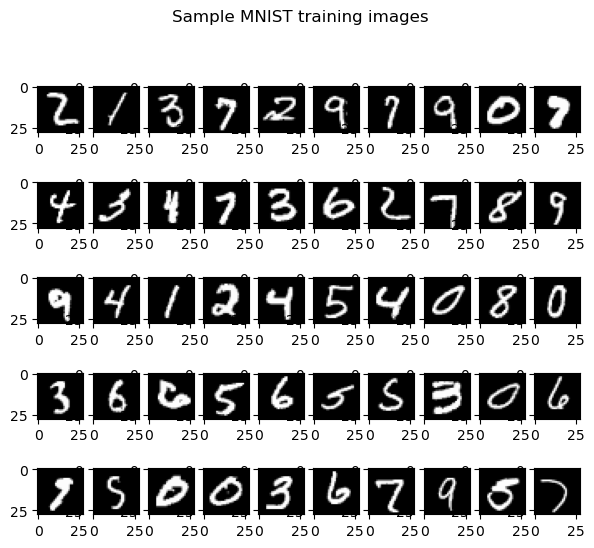

In [30]:
# Visualize images from training set-
plt.figure(figsize = (7, 6))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [31]:
del images

### Define Variational Autoencoder architecture using _convolutional_ layers

In [32]:
class LeNet_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Encoder, self).__init__()
        
        self.latent_space = latent_space
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, stride = 2,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.dense = nn.Linear(
            in_features = 64, out_features = 10,
            bias = True
        )
        '''
        self.dense2 = nn.Linear(
            in_features = 30, out_features = 10,
            bias = True
        )
        '''
        self.encoder_output = nn.Linear(
            in_features = 10, out_features = self.latent_space,
            bias = True
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # print(f"before flatten, x.shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dense(x))
        # x = F.leaky_relu(self.dense2(x))
        x = F.leaky_relu(self.encoder_output(x))
        return x
        
        
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"conv1 output shape: {x.shape}")
        x = self.conv2(x)
        print(f"conv2 output shape: {x.shape}")
        x = self.conv3(x)
        print(f"conv3 output shape: {x.shape}")
        x = self.conv4(x)
        print(f"conv4 output shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        print(f"flattened shape: {x.shape}")
        x = self.dense(x)
        print(f"dense output shape: {x.shape}")
        # x = self.dense2(x)
        # print(f"dense2 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"encoder output shape: {x.shape}")
        del x
        return None
        

In [33]:
class LeNet_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Decoder, self).__init__()
        
        self.latent_space = latent_space
        self.dense_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 10,
            bias = True
        )
        
        self.dense_layer2 = nn.Linear(
            in_features = 10, out_features = 64,
            bias = True
        )
        '''
        self.dense_layer3 = nn.Linear(
            in_features = 30, out_features = 64,
            bias = True
        )
        '''
        self.conv_tran_layer1 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer2 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer3 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 6,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.op_conv_tran_layer = nn.ConvTranspose2d(
            in_channels = 6, out_channels = 1,
            kernel_size = 2, stride = 2,
            padding = 0
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        # x = F.leaky_relu(self.dense_layer3(x))
        x = x.view(-1, 16, 2, 2)
        x = F.leaky_relu(self.conv_tran_layer1(x))
        x = F.leaky_relu(self.conv_tran_layer2(x))
        x = F.leaky_relu(self.conv_tran_layer3(x))
        x = self.op_conv_tran_layer(x)
        return x
 

    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.dense_layer1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense_layer2(x)
        print(f"dense2 output shape: {x.shape}")
        # x = self.dense_layer3(x)
        # print(f"dense3 output shape: {x.shape}")
        x = x.view(-1, 16, 2, 2)
        print(f"reshaped output shape: {x.shape}")
        x = self.conv_tran_layer1(x)
        print(f"conv transpose1 output shape: {x.shape}")
        x = self.conv_tran_layer2(x)
        print(f"conv transpose2 output shape: {x.shape}")
        x = self.conv_tran_layer3(x)
        print(f"conv transpose3 output shape: {x.shape}")
        x = self.op_conv_tran_layer(x)
        print(f"decoder output shape: {x.shape}")
        del x
        return None


In [34]:
class VAE_Conv(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Conv, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'mu' & 'log_var' to convert the bottleneck into the μ and σ vectors-
        self.mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.decoder = LeNet_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
    
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        # Decode latent vector-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        
        return recon_data, mu, log_var
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        x = self.decoder(z)
        print(f"Decoder output shape: {x.shape}")
        del x, mu, log_var, z
        return None
    
    

In [35]:
# Initialize a VAE objetc-
model = VAE_Conv(latent_space = 3).to(device)

In [36]:
# print(model)

In [37]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([6, 1, 3, 3]) has 54 parameters
layer.shape = torch.Size([6]) has 6 parameters
layer.shape = torch.Size([16, 6, 5, 5]) has 2400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([10, 64]) has 640 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([3, 10]) has 30 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([10, 3]) has 30 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([64, 10]) has 640 parameters
layer.shape = to

In [38]:
print(f"Total number of parameters in VAE Conv model = {tot_params}")

Total number of parameters in VAE Conv model = 32022


In [39]:
# Sanity check-
images = next(iter(train_loader))
images = images.to(device)

In [40]:
images.shape

torch.Size([256, 1, 28, 28])

In [41]:
images.min(), images.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [42]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [43]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 3]), torch.Size([256, 3]))

In [44]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

(array(0.5823842, dtype=float32), array(0.6568895, dtype=float32))

In [45]:
del recon_images, images, mu, log_var

In [46]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [47]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [48]:
def total_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    # kl_div.shape
    # torch.Size([32])
    
    batchsize = kl_div.size(0)

    # Average over batch dimension-
    kl_div = kl_div.mean()
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([32])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + (beta * kl_div)
    
    return final_loss, recon_loss, kl_div


In [49]:
def train_one_epoch(model, dataloader, alpha, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        # total = int(len(train_dataset) / dataloader.batch_size)
        total = int(len(train) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        # data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon_data, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = total_loss(
            data = data, data_recon = recon_data,
            mu = mu, log_var = logvar,
            alpha = alpha, beta = beta
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


In [50]:
def validate_one_epoch(model, dataloader, alpha, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            # total = int(len(test_dataset) / dataloader.batch_size)):
            total = int(len(test) / test_loader.batch_size)):
          
            # Ignore labels-
            # data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            recon_data, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = total_loss(
                data = data, data_recon = recon_data,
                mu = mu, log_var = logvar,
                alpha = alpha, beta = beta
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss

    

### Train VAE model 

In [51]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1
beta = 1

In [52]:
# Python dict to contain training metrics-
train_history = {}

In [53]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 60 epochs


In [54]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000
# loc_patience = 0

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [ ]:
for epoch in range(1, num_epochs + 1):
    '''
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha, beta = beta
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha, beta = beta
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f}",
          f" & val recon loss = {val_recon_loss:.4f}"
         )
    
    
    # Code for manual Early Stopping:
    if (val_loss < best_val_loss):
    # (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        # loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet5_MNIST_best_model.pth")
        
    '''
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''
    
    

In [56]:
import pickle

# Save training history as pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

In [ ]:
# Save trained VAE model's weights-
# torch.save(model.state_dict(), 'VAE_LeNet5_MNIST_Trained_Weights.pth')

In [57]:
del model

In [58]:
# Load 'best' trained weights from before-
trained_model = VAE_Conv(latent_space = 3).to(device)
trained_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_best_model.pth'))
# trained_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_best_model.pth', map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

### Visualize training metrics

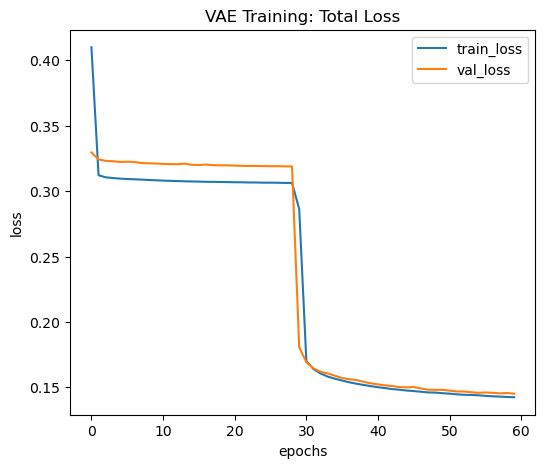

In [59]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Total Loss")
plt.show()

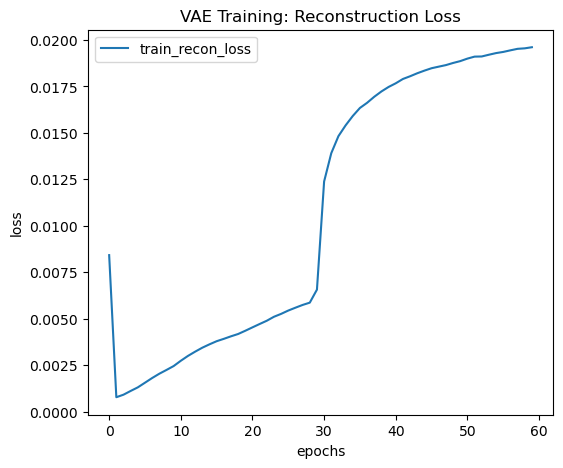

In [60]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

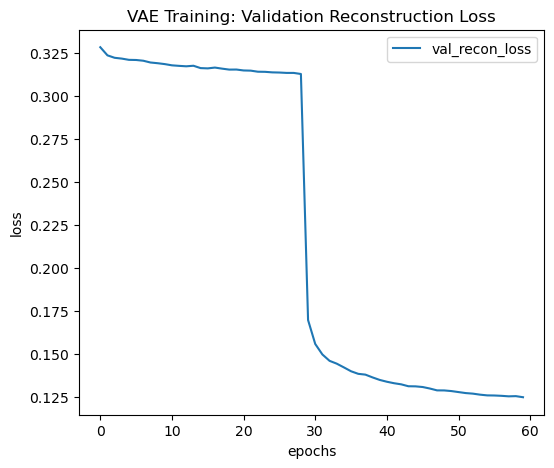

In [61]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Validation Reconstruction Loss")
plt.show()

_Reconstruction loss_ has 2 plots since training and validation losses are on different scales.

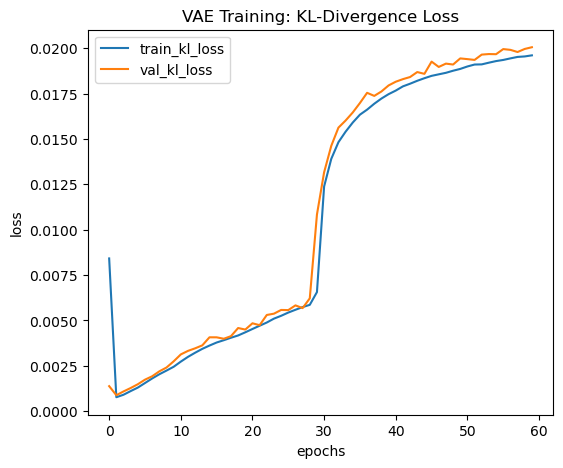

In [62]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: KL-Divergence Loss")
plt.show()

#### Synthesize MNIST images by sampling from a _standard Normal_ distribution and feeding through decoder

In [63]:
synthesized_images = []

In [64]:
for _ in test_loader:
    z = torch.randn(batch_size, 3).to(device)
    pred = torch.sigmoid(trained_model.decoder(z)).cpu().detach().numpy()
    synthesized_images.append(pred)

In [65]:
synthesized_images = np.vstack(synthesized_images)
synthesized_images = np.transpose(synthesized_images, (0, 2, 3, 1))

In [66]:
synthesized_images.shape

(10240, 28, 28, 1)

In [67]:
# De-normalize the batch of images-
synthesized_images *= 255.0

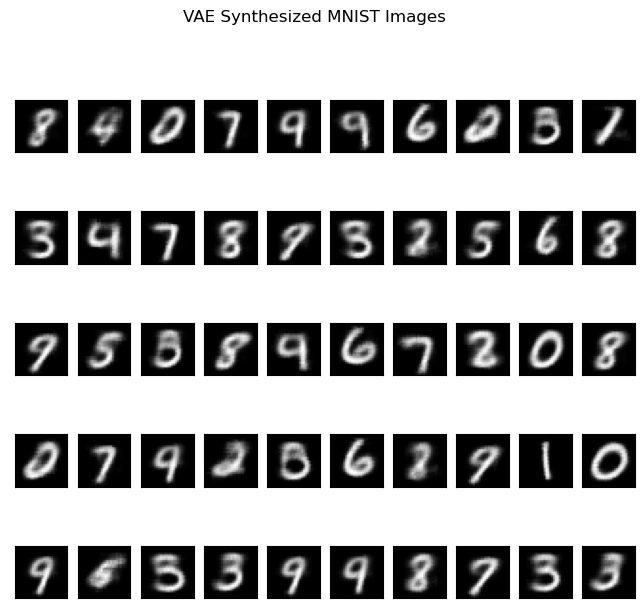

In [71]:
# Visualize synthesized images-
plt.figure(figsize = (8, 7))
for i in range(50):
    # 5 rows and 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(synthesized_images[i], cmap = 'gray')

    # get current axes-
    ax = plt.gca()
    
    # hide x-axis-
    ax.get_xaxis().set_visible(False)
    
    # hide y-axis-
    ax.get_yaxis().set_visible(False)


plt.suptitle("VAE Synthesized MNIST Images")
plt.show()

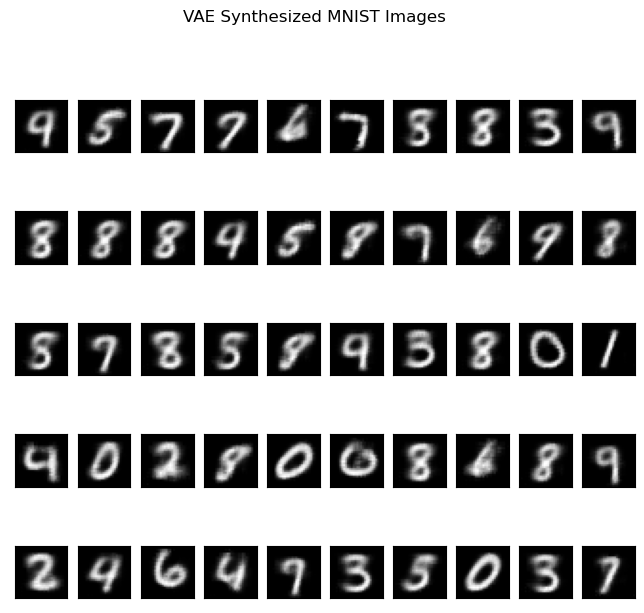

In [70]:
# Visualize synthesized images-
plt.figure(figsize = (8, 7))
for i in range(50):
    # 5 rows and 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(synthesized_images[i + 5000], cmap = 'gray')
    
    # get current axes-
    ax = plt.gca()
    
    # hide x-axis-
    ax.get_xaxis().set_visible(False)
    
    # hide y-axis-
    ax.get_yaxis().set_visible(False)

plt.suptitle("VAE Synthesized MNIST Images")
plt.show()

In [72]:
del synthesized_images

In [73]:
recon_images = []
mu_l = []
logvar_l = []

In [74]:
for x_v in test_loader:
    x_v = x_v.to(device)
    x_recon, mu, logvar = trained_model(x_v)
    x_recon = x_recon.cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()
    logvar = logvar.cpu().detach().numpy()
    recon_images.append(x_recon)
    mu_l.append(mu)
    logvar_l.append(logvar)

In [75]:
del x_recon, mu, logvar

In [76]:
recon_images = np.vstack(recon_images)
mu_l = np.vstack(mu_l)
logvar_l = np.vstack(logvar_l)

In [77]:
recon_images = np.transpose(recon_images, (0, 2, 3, 1))

In [78]:
# Sanity check-
recon_images.shape, mu_l.shape, logvar_l.shape

((10000, 28, 28, 1), (10000, 3), (10000, 3))

In [79]:
# De-normalize the batch of images-
recon_images *= 255.0

In [ ]:
# Visualize latent space for 'mu' vector-
fig = px.scatter_3d(
    x = mu_l[:, 0], y = mu_l[:, 1],
    z = mu_l[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance' vector-
fig = px.scatter_3d(
    x = logvar_l[:, 0], y = logvar_l[:, 1],
    z = logvar_l[:, 2],
    # color = y_train
    )
fig.show()

In [82]:
print(f"Mean vector (mu): mean = {mu_l.mean():4f} & std dev = {mu_l.std():.4f}")
print(f"log-variance (log-var): mean = {logvar_l.mean():.4f} & std dev = {logvar_l.std():.4f}")

Mean vector (mu): mean = 0.057676 & std dev = 0.8172
log-variance (log-var): mean = -3.3379 & std dev = 2.3989


In [83]:
np.mean(mu_l, axis = 0)

array([-0.00577948,  0.15353265,  0.02527507], dtype=float32)

In [84]:
np.mean(logvar_l, axis = 0)

array([-3.2395241e-03, -4.9743533e+00, -5.0361619e+00], dtype=float32)

In [85]:
for i in range(3):
    print(f"lv = {i + 1}: mean = {recon_images[:, i].mean():.4f} & std dev ="
          f" {recon_images[:, i].std():.4f}"
         )

lv = 1: mean = 0.1563 & std dev = 0.6483
lv = 2: mean = 0.0011 & std dev = 0.0099
lv = 3: mean = 1.0185 & std dev = 6.1282


In [86]:
del recon_images, mu_l, logvar_l

#### Notes:

Increasing ```beta``` from 1 to 2, 5 and 10 reproduces black or fuzzy synthesized images.